In [1]:
import re, string,os
from glob import glob as gb
import pandas as pd
from collections import Counter
from tqdm import tqdm
from utils.functions import *
import seaborn as sns 
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
import operator

plotting.style()

In [2]:
project_path = '/home/ruben/Documents/GitHub/CrisisBureaucracy'
data_path = '/media/ruben/Elements/PhD/data/hansard'

In [3]:
# Load all sentences with 'bureaucracy' (not just annotated set, but everything: 4080 texts)
df = pd.read_csv('~/Documents/GitHub/CrisisBureaucracy/data/classifier/bureaucracy-sentences-full.tsv',sep='\t').dropna()

def load_full(id_):
    f = pd.read_csv(f'{data_path}/lemmatized_pm/uk.proc.d.{id_[:10]}.txt',sep='\t')
    return [list(f[f['id'] == 'uk.proc.d.' + id_]['text'])[0],list(f[f['id'] == 'uk.proc.d.' + id_]['text_lemmatized'])[0]]

    
df['text'] = [load_full("-".join(x.split('-')[1:-1]))[0] for x in tqdm(df['id'])]
df = df[['id','text']]

100%|██████████| 4080/4080 [01:58<00:00, 34.44it/s]


In [4]:
# Preprocess text (remove stopwords, remove punctuation, lowercase)
df['text'] = utils.preprocess_(df['text'],stopwords=stopwords.words('english') + "hon member friend gentleman gentlemen speaker right".split(' '))

In [5]:
# Split metadata to columns
df['year'] = [int(x.split('-')[1]) for x in df.id]
df['party'] = [str(x.split('-')[-1]) for x in df.id]
df['id'] = ["-".join(x.split('-')[1:-1]) for x in df.id]

In [9]:
# Get Category Lexicons
lex_df = pd.read_csv(project_path + '/data/classifier/lexicon.csv')
lex_ = {c:[w for w in lex_df[c] if str(w) != 'nan'] for c in lex_df.columns}
vocab = list(set([item for sublist in list(lex_.values()) for item in sublist if str(item) != "nan"]))
vocab_texts = [[w for w in t.split(' ')] for t in df['text']]
vocab_texts = [item for sublist in vocab_texts for item in sublist]

In [11]:
# Create TFIDF Matrix with category lexicon as vocab
# max_df op default
tfidf_vec = TfidfVectorizer(vocabulary=vocab,ngram_range=(1,3),max_df=0.5,min_df=0.05,smooth_idf=True,sublinear_tf=True)
mtrx = tfidf_vec.fit_transform(df.text)
dfm = pd.DataFrame.sparse.from_spmatrix(mtrx)
dfm.index = df.id 
dfm.columns = vocab

In [12]:
# Aggregate Clusters in Matrix
dfm_ = pd.DataFrame()

for k,v in lex_.items():
    dfm_[k] = dfm[v].sum(axis=1) # summing the tfidf scores per category
dfm_['year'] = [int(x.split('-')[0]) for x in dfm_.index]
dfmd = dfm_.groupby('year').sum().T

# # Normalise per Year and transform to rolling window
for c in list(dfmd.columns):
    dfmd[c] = dfmd[c] / dfmd[c].sum()
dfmd = dfmd.T.reset_index()

In [13]:
# ## Create plot with averages / year

# data = dfm_
# fig, ax = plt.subplots(figsize=(12,6))
# for c,cl in enumerate("power cost irrationality centralisation size freedom inefficiency accountability".split(' ')):
#     # plt.scatter(x=data['year'],y=data[cl],alpha=.1) for scatterplots, not necessary
#     avgs = pd.DataFrame([[m,data[data['year'] == m][cl].sum() / len(data[data['year'] == m])] for m in set(data['year'])],columns=['year',cl]).sort_values('year')
#     rm = avgs[cl].rolling(3, win_type='gaussian').mean(std=2)
#     plt.plot(avgs['year'],rm,label=cl,marker='o',c=sns.color_palette('Paired',9)[c])
# plt.legend(loc='upper left',bbox_to_anchor=(1,1.05),fontsize=20)

In [14]:
d = dfm_.reset_index()
d['party'] =  df['party']

In [15]:
def average_year_party(data,category):
    d = data[['year','party'] + [category]].groupby(['year','party']).mean().reset_index().pivot(index='year',columns='party',values=category).reset_index()
    d = d[['year','conservative','labour']]
    for c in ['conservative','labour']:
        d[c] = d[c].rolling(3,win_type='gaussian').mean(std=3)
    return d[d['year'] <= 1980].reset_index(drop=True)

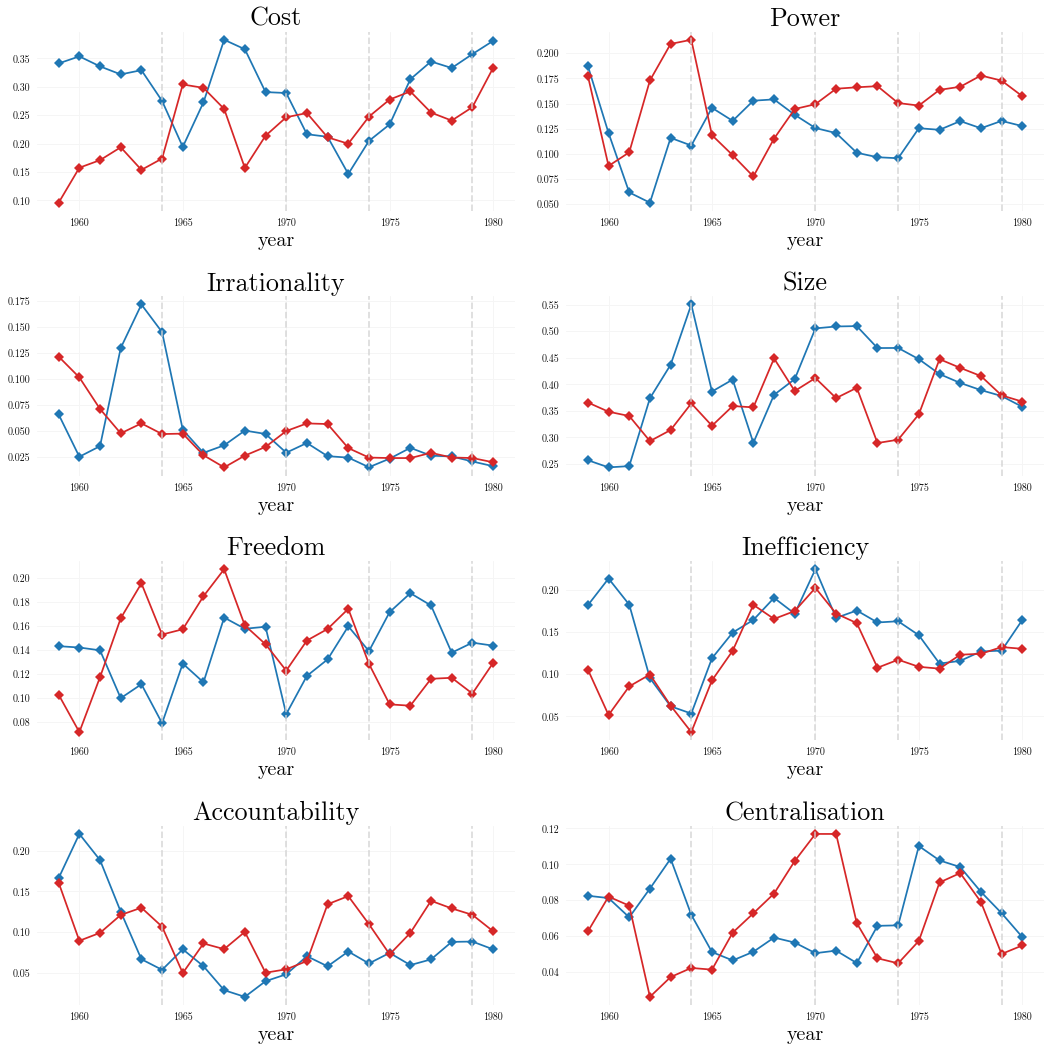

In [16]:
fig, axes = plt.subplots(nrows=4, ncols=2,figsize=(15,15))

average_year_party(d,'cost').plot(x='year',y=['conservative','labour'],marker='D',color=['tab:blue','tab:red'],legend=False,ax=axes[0,0],title='Cost')
average_year_party(d,'power').plot(x='year',y=['conservative','labour'],marker='D',color=['tab:blue','tab:red'],legend=False,ax=axes[0,1],title='Power')
average_year_party(d,'irrationality').plot(x='year',y=['conservative','labour'],marker='D',color=['tab:blue','tab:red'],legend=False,ax=axes[1,0],title='Irrationality')
average_year_party(d,'size').plot(x='year',y=['conservative','labour'],marker='D',color=['tab:blue','tab:red'],legend=False,ax=axes[1,1],title='Size')
average_year_party(d,'freedom').plot(x='year',y=['conservative','labour'],marker='D',color=['tab:blue','tab:red'],legend=False,ax=axes[2,0],title='Freedom')
average_year_party(d,'inefficiency').plot(x='year',y=['conservative','labour'],marker='D',color=['tab:blue','tab:red'],legend=False,ax=axes[2,1],title='Inefficiency')
average_year_party(d,'accountability').plot(x='year',y=['conservative','labour'],marker='D',color=['tab:blue','tab:red'],legend=False,ax=axes[3,0],title='Accountability')
average_year_party(d,'centralisation').plot(x='year',y=['conservative','labour'],marker='D',color=['tab:blue','tab:red'],legend=False,ax=axes[3,1],title='Centralisation')

fig.tight_layout()

for ax_ in axes:
    for i in [0,1]:
    # ax_.xlabel('')
        ax_[i].axvline(x=1964,linestyle='dashed',color='lightgrey',alpha=.8)
        ax_[i].axvline(x=1970,linestyle='dashed',color='lightgrey',alpha=.8)
        ax_[i].axvline(x=1974,linestyle='dashed',color='lightgrey',alpha=.8)
        ax_[i].axvline(x=1979,linestyle='dashed',color='lightgrey',alpha=.8)

# plt.savefig('/home/ruben/Documents/GitHub/CrisisBureaucracy/results/plots/argument-types-party.png',dpi=350)
plt.show()

In [111]:
def plot_lines_cat(data,words):
    data = data[words]
    data['year'] = [int(x[:4]) for x in data.index]
    data = data.groupby('year').sum().reset_index()
    data.plot(x='year',y=[c for c in data.columns if c != 'year'],legend=True,cmap='tab20b',figsize=(20,10))
    plt.legend(loc='upper left',bbox_to_anchor=(1.05,1),fontsize=20)


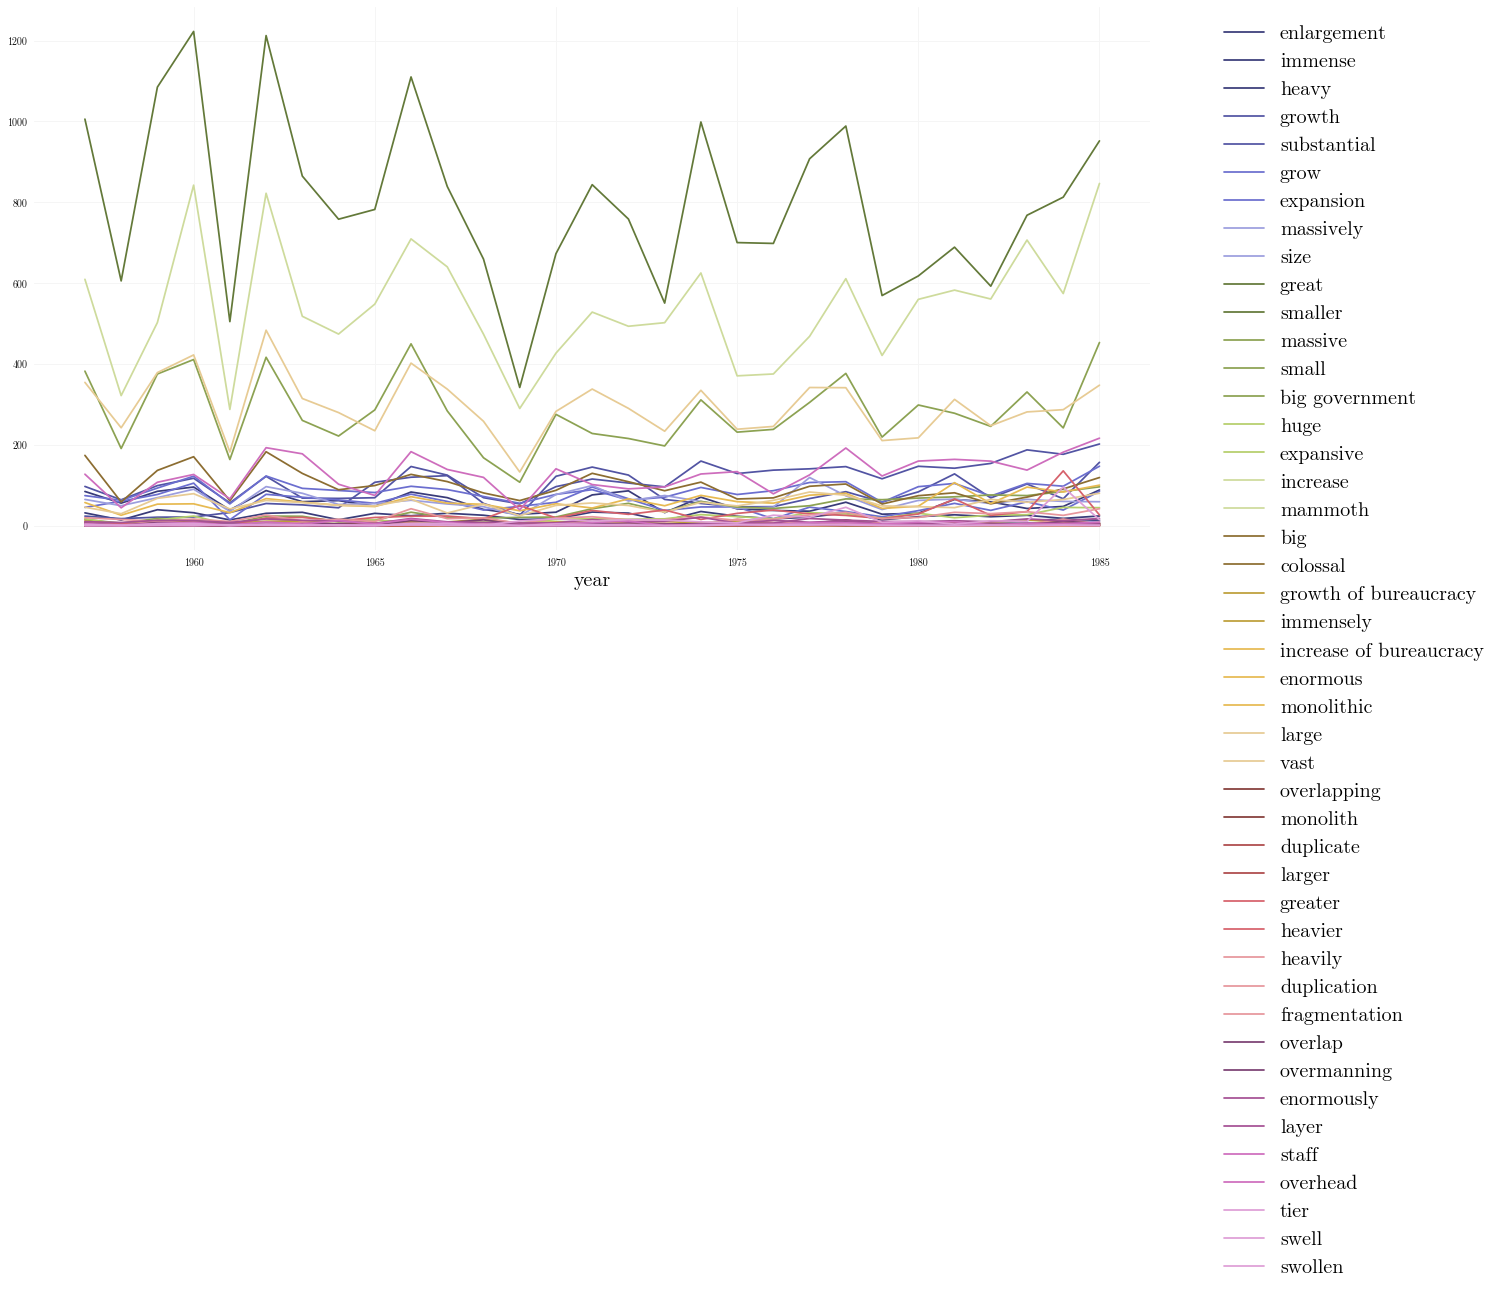

In [115]:
plot_lines_cat(dfm,lex_['size'])